# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


Посмотрим на данные повнимательнее 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Исследуем данные на предмет пропусков: где есть пропущенные значения, сколько их

In [3]:
print(df.isnull().sum())

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


Пропущенные (неизвестные) значения могут присутствовать неявным образом. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (в признаке со сферой занятости). Выявим, каким именно словом закодированы пропущенные (неизвестные) значения.

In [4]:
df['job'].sort_values()

0        admin.
2154     admin.
8198     admin.
2155     admin.
8202     admin.
         ...   
5805    unknown
5834    unknown
6338    unknown
4515    unknown
6985    unknown
Name: job, Length: 11162, dtype: object

В значениях признака "balance" так же присутствуют скрытые пропуски - значение NaN. Заменим их на медианные.
Кроме того, в значениях содержится запятая и знак доллара, поэтому не считывается как число. Преобразуем в тип float.

In [4]:
def balance_to_float(row): # функция, убирающая лишние знаки и пробелы
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row) # и возвращающая число
    else:
        return np.nan
    
df['balance'] = df['balance'].apply(balance_to_float) # применим функцию

In [5]:
# КОНТРОЛЬНАЯ ТОЧКА  1529.129

df['balance'].mean().round(3)

1529.129

In [6]:
# заменим нулевые значения на медианные
df['balance'] = df['balance'].fillna(value=df['balance'].median())

In [7]:
df['balance'].value_counts()

 0.0       774
 1.0        39
 2.0        34
 3.0        34
 550.0      31
          ... 
 1641.0      1
 5517.0      1
 8332.0      1
 4859.0      1
-134.0       1
Name: balance, Length: 3802, dtype: int64

In [8]:
# КОНТРОЛЬНАЯ ТОЧКА  1526.936

df['balance'].mean().round(3)

1526.936

Заменим неизвестные значения в признаках job и education на модальные

In [9]:
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)

In [10]:
# КОНТРОЛЬНАЯ ТОЧКА  1598.883

df_new = df[(df['job']=='management')&(df['education']=='secondary')]
df_new['balance'].mean().round(3)

1598.883

Поработаем с выбросами в признаке balance.

Cуществуют более продвинутые методы поиска аномальных значений, но для обработки одного числового признака достаточно хорошо подходит метод Тьюки (размах возьмем 1.5).

In [11]:
q1 = df.balance.quantile(0.25) # 25й персентиль
q3 = df.balance.quantile(0.75) # 75й персентиль
iqr = q3 - q1 # межкватильный размах
low = q1 - (iqr * 1.5) # нижняя граница
up = q3 + (iqr * 1.5) # верхняя граница
# отбросим значения, которые лежат за границами
df = df[(df['balance'] >= low) & (df['balance'] <= up)] 

In [12]:
# КОНТРОЛЬНАЯ ТОЧКА 10105

df.shape

(10105, 17)

## Часть 2:  Разведывательный анализ

### Изучим соотношение классов в целевой переменной

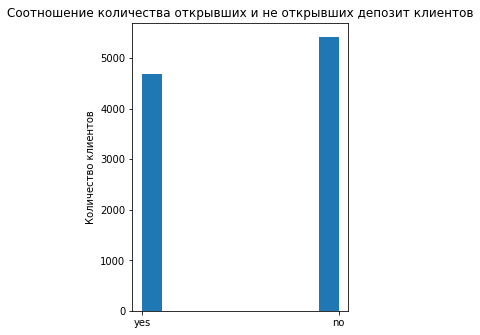

In [13]:
fig = plt.figure(figsize=(3, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(x=df['deposit'])
axes.set_title('Соотношение количества открывших и не открывших депозит клиентов')
axes.set_ylabel('Количество клиентов')
plt.show()

Соотношение клиетов, открывших депозит и не открывших достаточно сбалансировано.
Посмотрим точное количество пользователей, открывших депозит.

In [14]:
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задания 2 и 3

In [16]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

### Задания 4 и 5

In [17]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [18]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [19]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

### Задание 8

In [20]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

### Задания 9 и 10

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [23]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [24]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [25]:
# преобразуйте уровни образования

### Задания 2 и 3

In [26]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [27]:
# создайте дамми-переменные

### Задания 5 и 6

In [28]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [29]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [30]:
# рассчитайте необходимые показатели

### Задание 9

In [31]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [32]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [33]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [34]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [35]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [36]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [37]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [38]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [39]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [40]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna